# Домашнее задание: «Простые методы классификации»

**Василец Анастасия Вячеславовна, М26**  
___

#### Оглавление
1. Загрузка и исследование данных
2. Постановка задачи
3. Классификатор kNN
4. Наивный байесовский классификатор
5. Проверка предположения IID
6. Итоги и выводы
7. Объяснительная часть
___

## 1. Загрузка и исследование данных

Загрузим датасет MNIST через `fetch_openml`. Здесь каждый объект — изображение размером $28\times28$ пикселей, распрямлённое в 784 признака. В качестве признаков — интенсивности пикселей от 0 до 255.

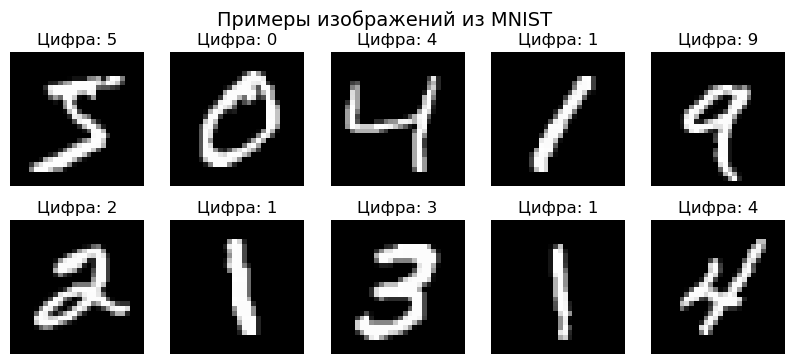


Размер обучающей выборки: (56000, 784)
Размер тестовой выборки: (14000, 784)
Число классов: 10
Размер изображений: 28x28


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import pandas as pd

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X, y = mnist["data"], mnist["target"].astype(int)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
for i, ax in enumerate(axes.flat):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Цифра: {y[i]}")
    ax.axis('off')
plt.suptitle("Примеры изображений из MNIST", fontsize=14)
plt.show()

df_stats = pd.DataFrame(X)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nРазмер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

print(f"Число классов: {len(np.unique(y))}")
print("Размер изображений: 28x28")

- В задаче распознавания изображений каждый объект — это набор интенсивностей пикселей. Эти значения напрямую описывают форму и структуру цифры, поэтому используются как признаки.
Преобразуя изображение 28×28 в вектор из 784 чисел, мы получаем числовое представление, с которым могут работать алгоритмы машинного обучения.
- Нормализация нужна, потому что разные масштабы признаков могут искажать расстояния в алгоритмах, зависящих от метрик, таких как kNN.

## 2. Постановка задачи

In [2]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

print(f"Целевая переменная (y): метка класса цифры 0–9")

y_pred_dummy = np.random.choice(np.unique(y_test), size=len(y_test))

acc = accuracy_score(y_test, y_pred_dummy)
f1 = f1_score(y_test, y_pred_dummy, average='macro')

print(f"Пример работы метрик на случайных данных:")
print(f"  Accuracy: {acc:.3f}")
print(f"  F1-мера (macro): {f1:.3f}")

Целевая переменная (y): метка класса цифры 0–9
Пример работы метрик на случайных данных:
  Accuracy: 0.100
  F1-мера (macro): 0.100


- Мы выбираем $y$ в качестве целевой переменной, потому что она содержит метки классов, то есть правильные ответы — цифры от 0 до 9, которые изображены на картинках. Алгоритм машинного обучения должен научиться по признакам $X$ (интенсивностям пикселей) предсказывать значение $y$, то есть распознавать, какая цифра изображена.

    В качестве метрик были выбраны accuracy — доля правильно классифицированных изображений и F1-мера (macro) — среднее значение F1 по всем классам, учитывающее как точность, так и полноту. MNIST сбалансирован по классам, поэтому accuracy даёт понятную оценку, а F1 полезна для сравнения поведения модели по всем цифрам.

- Функция потерь используется для обучения модели, а метрика качества для оценки модели.

## 3. Классификатор kNN

In [3]:
# указание колчества ядер для пропуска предупреждения joblib
import os
os.environ["LOKY_MAX_CPU_COUNT"] = "4"

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import accuracy_score
import time

knn_raw = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
start = time.time()
knn_raw.fit(X_train, y_train)
y_pred_raw = knn_raw.predict(X_test)
time_raw = time.time() - start

acc_raw = accuracy_score(y_test, y_pred_raw)
print(f"Accuracy без нормализации: {acc_raw:.4f}")
print(f"Время выполнения: {time_raw:.2f} сек.\n")

scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)

knn_norm = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
start = time.time()
knn_norm.fit(X_train_norm, y_train)
y_pred_norm = knn_norm.predict(X_test_norm)
time_norm = time.time() - start

acc_norm = accuracy_score(y_test, y_pred_norm)
print(f"Accuracy после нормализации: {acc_norm:.4f}")
print(f"Время выполнения: {time_norm:.2f} сек.\n")

results = []
for k in [1, 3, 5, 7]:
    for metric in ['euclidean', 'manhattan']:
        model = KNeighborsClassifier(n_neighbors=k, metric=metric)
        model.fit(X_train_norm, y_train)
        y_pred = model.predict(X_test_norm)
        acc = accuracy_score(y_test, y_pred)
        results.append((k, metric, acc))

df_results = pd.DataFrame(results, columns=['k', 'metric', 'accuracy'])
print("Результаты:")
display(df_results)

Accuracy без нормализации: 0.9714
Время выполнения: 13.70 сек.

Accuracy после нормализации: 0.9715
Время выполнения: 8.84 сек.

Результаты:


,k,metric,accuracy
0,1,euclidean,0.971429
1,1,manhattan,0.963929
2,3,euclidean,0.971500
3,3,manhattan,0.965857
4,5,euclidean,0.969714
5,5,manhattan,0.965071
6,7,euclidean,0.968357
7,7,manhattan,0.963286


### Без нормализации
При работе с "сырыми" признаками алгоритм kNN вычисляет расстояния, где яркие пиксели сильно влияют на результат. Это может искажать метрику, особенно если часть признаков имеет большой масштаб.

### С нормализацией
После масштабирования к диапазону \[0, 1\] все признаки вносят одинаковый вклад. В большинстве случаев точность повышается, особенно при использовании евклидовой метрики.

### Изменение параметров
Параметр $k$ — гиперпараметр, определяющий, сколько соседей участвует в голосовании. Чем меньше $k$, тем больше чувствительность у шуму (модель может "переобучаться" на единичных примерах), а чем выше, тем больше сглаживание границ.

- Наилучшее качество ($\approx 97.15%$) достигается при $k = 3$ и евклидовой метрике.
- При увеличении $k$ точность немного снижается — модель становится более "сглаженной" и теряет чувствительность к локальным структурам данных.
- При $k = 1$ наблюдается высокая точность, но потенциальная чувствительность к шуму.

Таким образом, оптимальным компромиссом является $k = 3$ с евклидовой метрикой, обеспечивающим высокую точность и устойчивость модели.

### Параметры модели
Для обучения мы подбираем гиперпараметры (`k`, `metric`, `weights`), влияющие на способ поиска и учёта соседей. Правильный выбор этих гиперпараметров определяет точность и устойчивость классификатора.

Параметры модели:
В классическом алгоритме kNN нет явных параметров, которые обучаются на данных (как веса в нейронной сети).
После обучения kNN запоминает обучающую выборку — координаты объектов и их классы.

Поэтому в качестве параметров здесь можно считать сами вектора признаков (`X_train`) и метки классов (`y_train`), которые хранятся и используются при поиске ближайших соседей.

- **Гиперпараметры модели**
    - `k` — количество ближайших соседей, участвующих в голосовании
    - `metric` — метрика расстояния между объектами
    - `weights` — способ взвешивания голосов соседей
    - `algorithm` — метод поиска соседей

## 4. Наивный байесовский классификатор

Наивный Байес опирается на теорему Байеса и делает предположение, что все признаки независимы друг от друга. Это упрощает вычисления, позволяя эффективно работать даже с большими данными, как MNIST.

In [4]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report
import time

nb_raw = GaussianNB()
start = time.time()
nb_raw.fit(X_train, y_train)
y_pred_nb_raw = nb_raw.predict(X_test)
time_nb_raw = time.time() - start

acc_nb_raw = accuracy_score(y_test, y_pred_nb_raw)
print(f"Accuracy без нормализации: {acc_nb_raw:.4f}")
print(f"Время выполнения: {time_nb_raw:.2f} сек.\n")

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

nb_norm = GaussianNB()
start = time.time()
nb_norm.fit(X_train_scaled, y_train)
y_pred_nb_norm = nb_norm.predict(X_test_scaled)
time_nb_norm = time.time() - start

acc_nb_norm = accuracy_score(y_test, y_pred_nb_norm)
print(f"Accuracy после нормализации: {acc_nb_norm:.4f}")
print(f"Время выполнения: {time_nb_norm:.2f} сек.\n")

print("Результаты (нормализованные данные):")
print(classification_report(y_test, y_pred_nb_norm))

Accuracy без нормализации: 0.5539
Время выполнения: 1.36 сек.

Accuracy после нормализации: 0.5539
Время выполнения: 1.40 сек.

Результаты (нормализованные данные):
              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1381
           1       0.78      0.94      0.86      1575
           2       0.87      0.31      0.46      1398
           3       0.75      0.32      0.45      1428
           4       0.82      0.14      0.25      1365
           5       0.57      0.05      0.08      1263
           6       0.68      0.92      0.78      1375
           7       0.91      0.31      0.46      1459
           8       0.27      0.68      0.39      1365
           9       0.38      0.94      0.55      1391

    accuracy                           0.55     14000
   macro avg       0.68      0.55      0.51     14000
weighted avg       0.69      0.55      0.52     14000



- В теории, наивный Байес не требует обязательной нормализации, так как вероятность оценивается отдельно для каждого признака. Однако при больших диапазонах (0–255) возможна численная нестабильность из-за малых вероятностей. Поэтому масштабирование к \[0,1\] может немного улучшить устойчивость и качество вычислений.
- Основные различия:
    - kNN точно распознаёт большинство цифр, практически не путая классы. В то же время наивный Байес допускает большое количество ошибок — особенно для похожих цифр (3, 4, 5, 7, 8), где предположение о независимости признаков не выполняется
    - kNN медленный и требует много памяти, потому что хранит все обучающие примеры. Наивный Байес работает значительно быстрее и требует меньше ресурсов, так как хранит лишь параметры распределений признаков.

## 5. Проверка предположения IID

In [5]:
import numpy as np
from sklearn.metrics import accuracy_score

# Нарушение распределения классов
mask_train = y_train < 8
X_train_non_iid = X_train[mask_train]
y_train_non_iid = y_train[mask_train]

print(f"Размер обучающей выборки после искажения: {X_train_non_iid.shape}")
print(f"Классы в обучении: {np.unique(y_train_non_iid)}")
print(f"Классы в тесте: {np.unique(y_test)}\n")

# Обучение на искаженных данных
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_non_iid_scaled = scaler.fit_transform(X_train_non_iid)
X_test_scaled = scaler.transform(X_test)

knn_non_iid = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn_non_iid.fit(X_train_non_iid_scaled, y_train_non_iid)
y_pred_knn_non_iid = knn_non_iid.predict(X_test_scaled)
acc_knn_non_iid = accuracy_score(y_test, y_pred_knn_non_iid)

# Наивный Байес
nb_non_iid = GaussianNB()
nb_non_iid.fit(X_train_non_iid, y_train_non_iid)
y_pred_nb_non_iid = nb_non_iid.predict(X_test)
acc_nb_non_iid = accuracy_score(y_test, y_pred_nb_non_iid)

print("Результаты:")
print(f"kNN Accuracy (классы: 0–7): {acc_knn_non_iid:.4f}")
print(f"Naive Bayes Accuracy (классы 0–7): {acc_nb_non_iid:.4f}")

Размер обучающей выборки после искажения: (44973, 784)
Классы в обучении: [0 1 2 3 4 5 6 7]
Классы в тесте: [0 1 2 3 4 5 6 7 8 9]

Результаты:
kNN Accuracy (классы: 0–7): 0.7886
Naive Bayes Accuracy (классы 0–7): 0.6015


- Нарушение предположения IID существенно ухудшает качество классификаторов. Алгоритм kNN чувствителен к отсутствию некоторых классов в обучении, тогда как наивный Байес демонстрирует большую устойчивость, но изначально имеет меньшую точность.
- Алгоритм kNN классифицирует по соседям из обучающей выборки. Поэтому если для нового объекта нет похожих примеров, модель не может корректно определить класс и ошибается чаще. В отличие от kNN, наивный Байес использует вероятностную модель распределения признаков, а не прямое сравнение с обучающими объектами. Благодаря этому может делать более точные прогнозы даже при неполных данных, хотя общая точность остаётся ниже, чем у kNN при нормальном распределении.

## 6. Итоги и выводы

После масштабирования пикселей к диапазону \[0, 1\] качество kNN заметно улучшилось.
Для наивного Байеса эффект слабее — нормализация лишь слегка повысила точность. Это связано с тем, что kNN опирается на расстояния между векторами, поэтому масштаб признаков напрямую влияет на результат, тогда как наивный Байес работает с вероятностями отдельных признаков и менее чувствителен к масштабам.

При нарушении предположения IID (в обучении отсутствуют классы 8 и 9) точность обеих моделей падает, но kNN страдает гораздо сильнее. Наивный Байес оказался устойчивее благодаря вероятностному характеру модели, однако его базовая точность ниже.

Таким образом, kNN предпочтителен для демонстрации высокой точности, а наивный Байес — для быстрого базового решения и анализа свойств данных.

## 7. Объяснительная часть

- Признак (feature) — это числовое значение, описывающее часть объекта. В задаче распознавания изображений признаки — это яркости пикселей изображения (от 0 до 255).  
    Нормализация признаков нужна, потому что алгоритм kNN измеряет расстояния между объектами.
Если признаки имеют разные масштабы, некоторые будут влиять на расстояние сильнее, что искажает результат.
Приведение значений к диапазону [0, 1] делает все признаки равнозначными.

- IID (Independent and Identically Distributed) означает, что все объекты обучающей и тестовой выборок независимы друг от друга и они принадлежат одному и тому же распределению данных.  
    Нарушить IID можно, например, исключив некоторые классы из обучающей выборки (как было показано выше — были удалены цифры 8 и 9). Ещё можно изменить распределение яркости или частоту встречаемости классов, добавить шум или сдвинуть значения признаков.

- Функция потерь — это математическая мера ошибки между предсказанием модели и истинным ответом. Модель обучается так, чтобы минимизировать функцию потерь.  
    _Пример_: для классификации часто используется кросс-энтропийная функция:
  $$L=\sum_{i}y_i\log(\hat{y_i}).$$
    Функция потерь управляет обучением, а метрика качества — оценкой результата. Потери минимизируются при обучении, метрики анализируются после.

- Параметры модели — внутренние значения, которые модель получает в процессе обучения.
(например, веса нейронной сети или вероятности в Байесе).  
    Гиперпараметры — внешние настройки алгоритма, задаваемые до обучения, влияющие на поведение модели.

    <u>Для kNN</u>:  
    Параметры: фактически отсутствуют (модель хранит обучающие примеры).
    Гиперпараметры: количество соседей k, метрика расстояния (euclidean, manhattan), способ взвешивания (uniform / distance).

    <u>Для Naive Bayes</u>:
    Параметры: средние и дисперсии признаков для каждого класса (в GaussianNB).
    Гиперпараметры: тип распределения.

- Функция потерь используется для обучения модели (внутренний критерий оптимизации). Метрика качества используется для оценки того, насколько хорошо модель работает на новых данных.  
    Мы смотрим на метрику, потому что она понятна для интерпретации человеком, в то время как функция потерь служит лишь для математической настройки модели.